# 1.2 Modeling and Tuning (40/100 points)

Construct an ML pipeline—using the prepared training and validation sets—for classifying the ECG
time series into the four classes. Figure 1 shows an optional model architecture. Choose an appropriate
loss function and evaluation metric and evaluate this metric on both the train and validation data.
Train models for at least two different model architectures, and tune the hyper-parameters of your
model (e.g., regularization parameters, channels, learning rate, optimizers, early stopping). Finally,
report the evaluation metric on the test data.

<b>Expected Results:</b> Runnable code for training and inference, as well as descriptions of the used
model architectures, ML pipelines, and their evaluation. The report must include statistics or plots
highlighting the quality of the trained models. You should further justify the selected architectures
and solutions, as well as reason why they are applicable to ECG data. Use your final model to produce
the base.csv predictions of the test dataset for your submission.

In [ ]:
import sys
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, parent_dir)
import utils
import joblib
import tensorflow
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Conv2D, MaxPooling2D, LSTM, Dense, Reshape, Dropout, BatchNormalization, Layer, Add, GlobalAveragePooling1D, Activation

# Custom callback to track learning rate during training
class LearningRateTracker(keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.learning_rates = []
    
    def on_epoch_end(self, epoch, logs=None):
        lr = float(self.model.optimizer.learning_rate)
        self.learning_rates.append(lr)
        if epoch % 5 == 0:  # Print every 5 epochs to avoid clutter
            print(f"Epoch {epoch + 1}: Learning rate = {lr:.2e}")

# Load preprocessed data and metadata
X_train_split, y_train_split = joblib.load("../processed/train_split.pkl")
X_val_split, y_val_split = joblib.load("../processed/val_split.pkl")
metadata = joblib.load("../processed/dataset_metadata.pkl")

/Users/burakpolat/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Define training parameters
EPOCHS = 50  # A higher number, but early stopping will find the best epoch
BATCH_SIZE = 16

## Step 1: Preprocessing

In [ ]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Based on the exploration, use a MAX_LEN of 8000.
MAX_LEN = 8000

print("Original data is a list of arrays.")
print(f"Number of training samples: {len(X_train_split)}")
print(f"Number of validation samples: {len(X_val_split)}")
print("-" * 30)

# Pad/truncate sequences to a fixed length
X_train_padded = pad_sequences(X_train_split, maxlen=MAX_LEN, dtype='float32', padding='post', truncating='post')
X_val_padded = pad_sequences(X_val_split, maxlen=MAX_LEN, dtype='float32', padding='post', truncating='post')

# Reshape for 1D CNN input, which expects a "channels" dimension
X_train_reshaped = np.expand_dims(X_train_padded, axis=-1)
X_val_reshaped = np.expand_dims(X_val_padded, axis=-1)

print("Shape of X_train after padding and reshape:", X_train_reshaped.shape)
print("Shape of X_val after padding and reshape:", X_val_reshaped.shape)
print("-" * 30)

# One-hot encode the labels for categorical cross-entropy
n_classes = len(metadata['class_names'])
print(f"Number of classes: {n_classes}")

y_train_encoded = to_categorical(y_train_split, num_classes=n_classes)
y_val_encoded = to_categorical(y_val_split, num_classes=n_classes)

print("Shape of y_train_encoded:", y_train_encoded.shape)
print("Shape of y_val_encoded:", y_val_encoded.shape)
print("\nSample of original labels:", y_train_split.values[:5])
print("Sample of one-hot encoded labels:\n", y_train_encoded[:5])

# Define the input shape for the models
input_shape = X_train_reshaped.shape[1:]
print(f"\nInput shape for models: {input_shape}")

Original data is a list of arrays.
Number of training samples: 4943
Number of validation samples: 1236
------------------------------
Shape of X_train after padding and reshape: (4943, 8000, 1)
Shape of X_val after padding and reshape: (1236, 8000, 1)
------------------------------
Number of classes: 4
Shape of y_train_encoded: (4943, 4)
Shape of y_val_encoded: (1236, 4)

Sample of original labels: [0 2 0 0 2]
Sample of one-hot encoded labels:
 [[1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]]

Input shape for models: (8000, 1)


## Step 2: Define the training models


### Model 0: Baseline RFTM


In [4]:
import tensorflow as tf

# Define a custom Keras Layer for the STFT operation
class STFTLayer(Layer):
    def __init__(self, frame_length=256, frame_step=128, fft_length=256, **kwargs):
        super(STFTLayer, self).__init__(**kwargs)
        self.frame_length = frame_length
        self.frame_step = frame_step
        self.fft_length = fft_length

    def call(self, inputs):
        # Squeeze the channel dimension, as tf.signal.stft expects a 2D or 3D tensor.
        x = tf.squeeze(inputs, axis=-1)

        # Perform STFT
        stfts = tf.signal.stft(x,
                               frame_length=self.frame_length,
                               frame_step=self.frame_step,
                               fft_length=self.fft_length)

        # Calculate the magnitude and apply a log scale for stability.
        x = tf.abs(stfts)
        x = tf.math.log(x + 1e-6)

        # Add the channel dimension back for the subsequent Conv2D layers.
        return tf.expand_dims(x, axis=-1)

    def get_config(self):
        config = super(STFTLayer, self).get_config()
        config.update({
            'frame_length': self.frame_length,
            'frame_step': self.frame_step,
            'fft_length': self.fft_length,
        })
        return config

# Custom layer for dynamic reshaping
class ReshapeForRNN(Layer):
    def __init__(self, **kwargs):
        super(ReshapeForRNN, self).__init__(**kwargs)

    def call(self, inputs):
        # Get the shape dynamically during execution
        shape = tf.shape(inputs)
        # Reshape to (batch_size, timesteps, features)
        return tf.reshape(inputs, (shape[0], shape[1], shape[2] * shape[3]))

    def get_config(self):
        return super(ReshapeForRNN, self).get_config()

def create_baseline_model(input_shape, n_classes):
    """
    Creates the baseline model with STFT, CNN, and RNN components.
    """
    inputs = Input(shape=input_shape)

    # 1. Custom STFT Layer
    stft_output = STFTLayer()(inputs)

    # 2. CNN Block 1
    conv1 = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(stft_output)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    # 3. CNN Block 2
    conv2 = Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(pool1)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # 4. Reshape for RNN using custom layer
    reshaped = ReshapeForRNN()(pool2)

    # 5. RNN Layer
    lstm = LSTM(units=80, return_sequences=False)(reshaped)
    dropout = Dropout(0.4)(lstm)

    # 6. Output Layer
    outputs = Dense(n_classes, activation='softmax')(dropout)

    model = Model(inputs=inputs, outputs=outputs)

    return model

### Model 1: 1D ResNet
A Residual Network (ResNet) is a deep learning model that uses "shortcut connections" to allow gradients to flow more easily through the network. This makes it possible to train much deeper models. Here, we adapt the ResNet architecture for 1D time series data.

In [ ]:
def resnet_block(x, filters, kernel_size, strides=1):
    shortcut = x

    # First component
    x = Conv1D(filters, kernel_size, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Second component
    x = Conv1D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)

    # Adjust shortcut if needed
    if strides > 1 or shortcut.shape[-1] != filters:
        shortcut = Conv1D(filters, 1, strides=strides, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def create_resnet_model(input_shape, n_classes):
    
    inputs = Input(shape=input_shape)

    # Initial convolution - smaller filters for ECG signals
    x = Conv1D(32, 7, strides=2, padding='same')(inputs) 
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(pool_size=3, strides=2, padding='same')(x)  # More aggressive downsampling

    # Stage 1: 32 filters, 2 blocks
    for _ in range(2):
        x = resnet_block(x, 32, 3)

    # Stage 2: 64 filters, 2 blocks
    for i in range(2):
        x = resnet_block(x, 64, 3, strides=2 if i == 0 else 1)

    # Stage 3: 128 filters, 2 blocks 
    for i in range(2):
        x = resnet_block(x, 128, 3, strides=2 if i == 0 else 1)

    # Classification head - simplified
    x = GlobalAveragePooling1D()(x)
    x = Dense(64, activation='relu')(x)  
    x = Dropout(0.3)(x) 
    outputs = Dense(n_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

## Step 3: Training the Models

### Training of the baseline RFTM

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 8000, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stft_layer_1 (STFTLayer)        │ (None, 61, 129, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 59, 127, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 59, 127, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 29, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 27, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 27, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 13, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_for_rnn_1               │ (None, 13, 1920)       │             0 │
│ (ReshapeForRNN)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 80)             │       640,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           324 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 659,844 (2.52 MB)

 Trainable params: 659,652 (2.52 MB)

 Non-trainable params: 192 (768.00 B)

Starting training for the baseline model...
Initial learning rate: 1e-05
Learning rate will be reduced by 50% if validation loss plateaus for 2 epochs
Epoch 1/50
308/309 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5171 - loss: 1.1716
Epoch 1: val_loss improved from inf to 1.02003, saving model to baseline_model.keras
Epoch 1: Learning rate = 1.00e-05
309/309 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.5174 - loss: 1.1709 - val_accuracy: 0.5623 - val_loss: 1.0200 - learning_rate: 1.0000e-05
Epoch 2/50
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5885 - loss: 0.9866
Epoch 2: val_loss improved from 1.02003 to 0.93327, saving model to baseline_model.keras
309/309 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - accuracy: 0.5885 - loss: 0.9866 - val_accuracy: 0.6117 - val_loss: 0.9333 - learning_rate: 1.0000e-05
Epoch 3/50
308/309 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5919 - loss: 0.9549
Epoch 3: val_loss improved from 0.93327 to 0.91471, saving model to baseline_model.ker

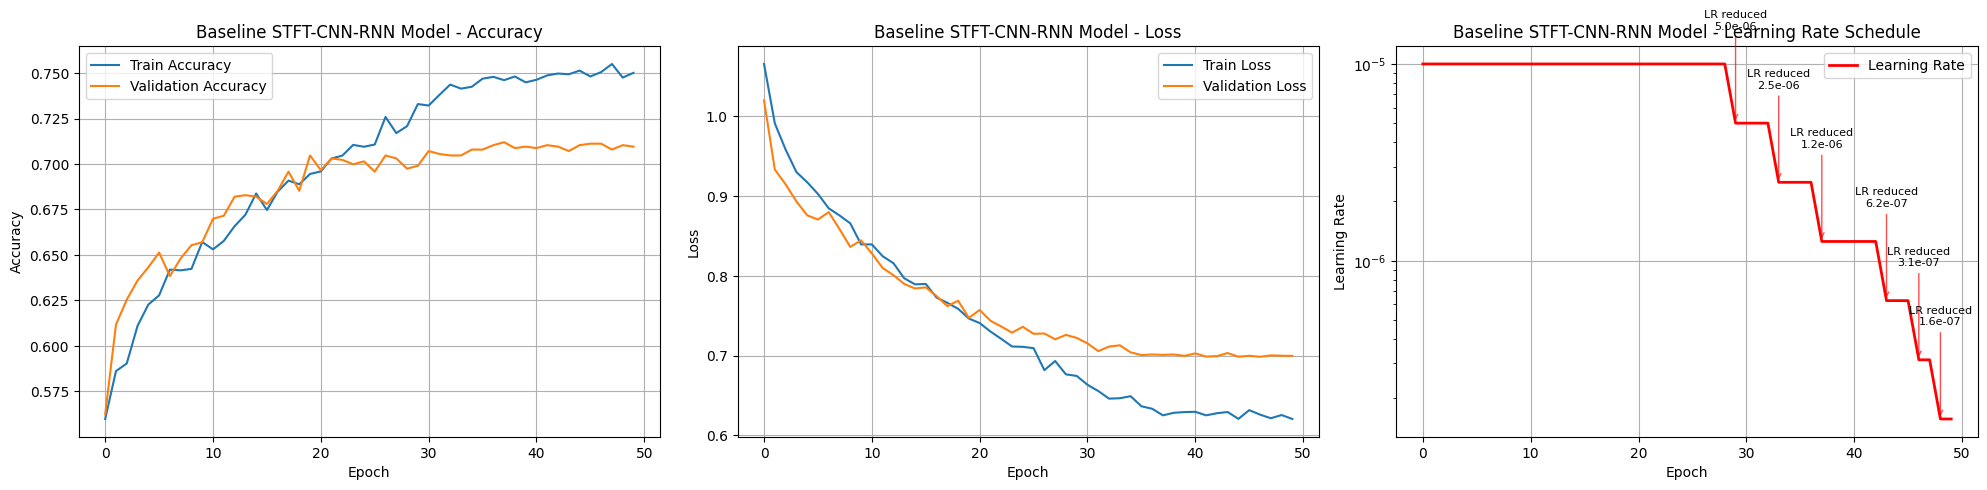

In [ ]:
# Create the baseline model
baseline_model = create_baseline_model(input_shape, n_classes)

# Baseline model prefers lower learning rate due to STFT complexity and RNN sensitivity
baseline_initial_lr = 0.00001 

# Compile the model
baseline_model.compile(optimizer=Adam(learning_rate=baseline_initial_lr),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

# Print model summary
baseline_model.summary()

# Define callbacks for training with learning rate scheduling
# Based on ECG data characteristics: moderate patience for complex patterns
baseline_lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,  # Reduce LR by half when plateau detected
    patience=2,   # Wait 2 epochs before reducing (ECG patterns can be complex)
    min_lr=1e-7,  # Minimum learning rate
    verbose=0,
    cooldown=1    # Wait 1 epochs after LR reduction before monitoring again
)

# Learning rate tracker
baseline_lr_tracker = LearningRateTracker()

# Early stopping with higher patience due to LR scheduling
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)

# Save the best model found during training
model_checkpoint = ModelCheckpoint('baseline_model.keras', save_best_only=True, monitor='val_loss', verbose=1)

# Train the baseline model
print("Starting training for the baseline model...")
print(f"Initial learning rate: {baseline_initial_lr}")
print("Learning rate will be reduced by 50% if validation loss plateaus for 2 epochs")

history_baseline = baseline_model.fit(
    X_train_reshaped,
    y_train_encoded,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val_reshaped, y_val_encoded),
    callbacks=[early_stopping, model_checkpoint, baseline_lr_scheduler, baseline_lr_tracker],
    verbose=1
)

print("\nBaseline model training complete.")
print(f"Final learning rate: {baseline_lr_tracker.learning_rates[-1]:.2e}")

# Plot training history with learning rate
utils.plot_history_with_lr(history_baseline, "Baseline STFT-CNN-RNN Model", baseline_lr_tracker)

### Training of the 1D ResNet Model


TRAINING 1D RESNET MODEL

 ResNet Architecture:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 8000, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 4000, 32)  │        256 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4000, 32)  │        128 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 4000, 32)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 2000, 32)  │          0 │ activation[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 2000, 32)  │      3,104 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2000, 32)  │        128 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 2000, 32)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 2000, 32)  │      3,104 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2000, 32)  │        128 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 2000, 32)  │          0 │ batch_normalizat… │
│                     │                   │            │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 2000, 32)  │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 2000, 32)  │      3,104 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2000, 32)  │        128 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 2000, 32)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 2000, 32)  │      3,104 │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2000, 32)  │        128 │ conv1d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 2000, 32)  │          0 │ batch_normalizat… │
│                     │                   │            │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 251,908 (984.02 KB)

 Trainable params: 249,668 (975.27 KB)

 Non-trainable params: 2,240 (8.75 KB)

Starting training for the 1D ResNet model...
Initial learning rate: 0.001
Learning rate will be reduced by 70% if validation loss plateaus for 3 epochs
Epoch 1/50
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.5540 - loss: 1.0264
Epoch 1: val_loss improved from inf to 1.04834, saving model to resnet_model.keras
Epoch 1: Learning rate = 1.00e-03
309/309 ━━━━━━━━━━━━━━━━━━━━ 37s 112ms/step - accuracy: 0.5540 - loss: 1.0262 - val_accuracy: 0.5922 - val_loss: 1.0483 - learning_rate: 0.0010
Epoch 2/50
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.6154 - loss: 0.9196
Epoch 2: val_loss did not improve from 1.04834
309/309 ━━━━━━━━━━━━━━━━━━━━ 34s 110ms/step - accuracy: 0.6154 - loss: 0.9195 - val_accuracy: 0.4652 - val_loss: 1.2534 - learning_rate: 0.0010
Epoch 3/50
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.6324 - loss: 0.8327
Epoch 3: val_loss improved from 1.04834 to 0.74631, saving model to resnet_model.keras
309/309 ━━━━━━━━━━━━━━━━━━━━ 32s 104ms/step - 

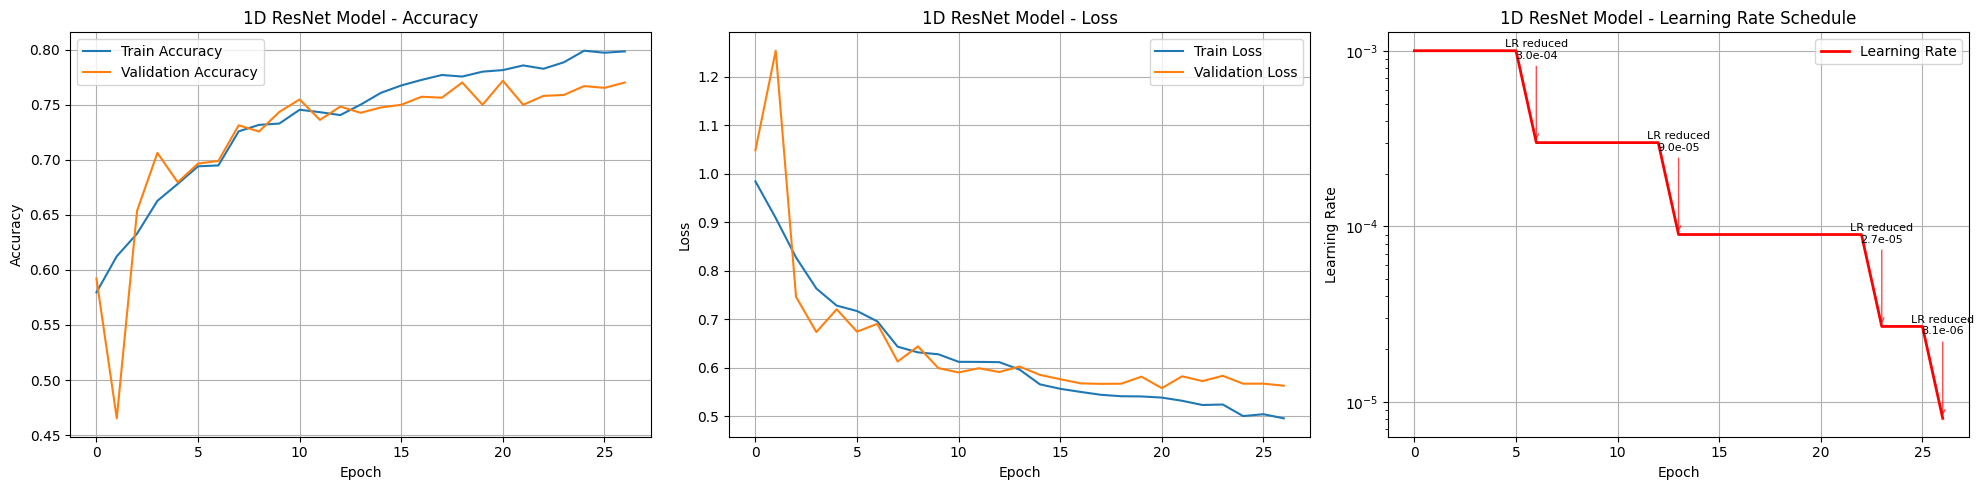

Models trained successfully!


In [ ]:
# Create and train the ResNet model
print("\n" + "="*50)
print("TRAINING 1D RESNET MODEL")
print("="*50)

resnet_model = create_resnet_model(input_shape, n_classes)

# ResNet can handle higher learning rates due to residual connections and batch normalization
resnet_initial_lr = 0.001  # Higher than baseline due to ResNet's stability

# Compile with higher learning rate for faster convergence
resnet_model.compile(optimizer=Adam(learning_rate=resnet_initial_lr), 
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# Print model summary
print("\n ResNet Architecture:")
resnet_model.summary()

# Learning rate scheduler for ResNet
# More aggressive scheduling due to ResNet's robustness
resnet_lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,   # More aggressive reduction (30% of current LR)
    patience=3,   # Shorter patience due to ResNet's faster convergence
    min_lr=1e-6,  # Slightly higher minimum LR
    verbose=0,
    cooldown=1    
)

# Learning rate tracker for ResNet
resnet_lr_tracker = LearningRateTracker()

# Define callbacks for training with adjusted patience
early_stopping_resnet = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)
model_checkpoint_resnet = ModelCheckpoint('resnet_model.keras', save_best_only=True, monitor='val_loss', verbose=1)

print("Starting training for the 1D ResNet model...")
print(f"Initial learning rate: {resnet_initial_lr}")
print("Learning rate will be reduced by 70% if validation loss plateaus for 3 epochs")

history_resnet = resnet_model.fit(
    X_train_reshaped,
    y_train_encoded,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val_reshaped, y_val_encoded),
    callbacks=[early_stopping_resnet, model_checkpoint_resnet, resnet_lr_scheduler, resnet_lr_tracker],
    verbose=1
)

print("\n1D ResNet model training complete.")
print(f"Final learning rate: {resnet_lr_tracker.learning_rates[-1]:.2e}")

# Plot training history with learning rate
utils.plot_history_with_lr(history_resnet, "1D ResNet Model", resnet_lr_tracker)

print("Models trained successfully!")
print("="*60)

## Step 4: Evaluate on Validation Set

COMPREHENSIVE MODEL EVALUATION

----------------------------------------
EVALUATING: Baseline STFT-CNN-RNN
----------------------------------------
 Baseline STFT-CNN-RNN - Validation Accuracy: 0.6837
   Parameters: 659,844

Classification Report for Baseline STFT-CNN-RNN:
              precision    recall  f1-score   support

           0       0.75      0.93      0.83       728
           1       0.38      0.12      0.18       110
           2       0.52      0.41      0.46       353
           3       0.57      0.27      0.36        45

    accuracy                           0.68      1236
   macro avg       0.56      0.43      0.46      1236
weighted avg       0.64      0.68      0.65      1236



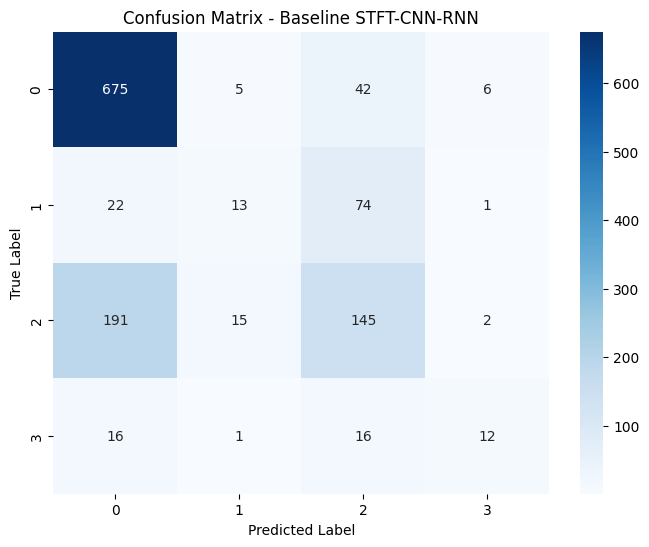


----------------------------------------
EVALUATING: Simplified ResNet
----------------------------------------
 Simplified ResNet - Validation Accuracy: 0.7718
   Parameters: 251,908

Classification Report for Simplified ResNet:
              precision    recall  f1-score   support

           0       0.81      0.90      0.85       728
           1       0.72      0.76      0.74       110
           2       0.68      0.53      0.59       353
           3       0.81      0.67      0.73        45

    accuracy                           0.77      1236
   macro avg       0.76      0.71      0.73      1236
weighted avg       0.76      0.77      0.76      1236



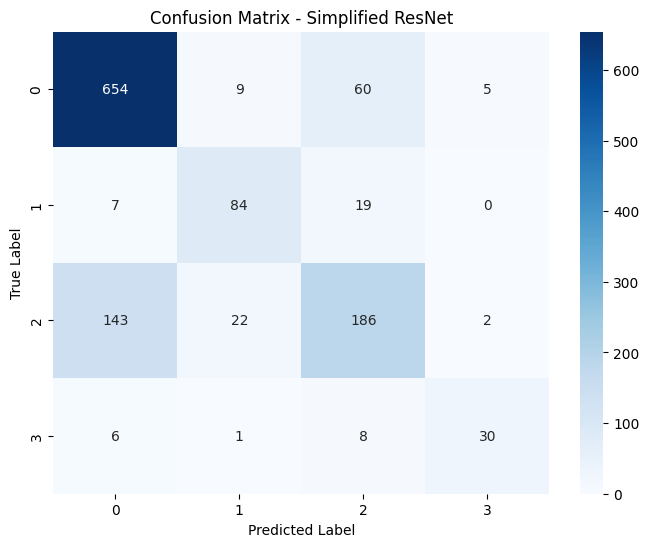


FINAL MODEL COMPARISON SUMMARY
                Model Accuracy Parameters
Baseline STFT-CNN-RNN   0.6837    659,844
    Simplified ResNet   0.7718    251,908

🏆 BEST MODEL: Simplified ResNet
   Accuracy: 0.7718
   Parameters: 251,908
   - Most efficient: Simplified ResNet (fewest parameters)

📊 TRADE-OFF ANALYSIS:
   Baseline STFT-CNN-RNN: 0.001036 (accuracy per 1K parameters)
   Simplified ResNet: 0.003064 (accuracy per 1K parameters)



In [ ]:
# Evaluate both models for comparison
print("="*60)
print("COMPREHENSIVE MODEL EVALUATION")
print("="*60)

# Define ground truth labels for validation set
y_true = y_val_split.values if hasattr(y_val_split, 'values') else np.array(y_val_split)

string_class_names = [str(name) for name in metadata['class_names']]

# Load both models
models_to_evaluate = {
    "Baseline STFT-CNN-RNN": {
        "file": "baseline_model.keras",
        "custom_objects": {'STFTLayer': STFTLayer, 'ReshapeForRNN': ReshapeForRNN}
    },
    "Simplified ResNet": {
        "file": "resnet_model.keras",
        "custom_objects": None
    }
}


evaluation_results = {}

for model_name, model_info in models_to_evaluate.items():
    print(f"\n{'-'*40}")
    print(f"EVALUATING: {model_name}")
    print(f"{'-'*40}")
    
    try:
        # Load model
        if model_info["custom_objects"]:
            model = load_model(model_info["file"], custom_objects=model_info["custom_objects"])
        else:
            model = load_model(model_info["file"])
        
        # Make predictions
        y_pred_probs = model.predict(X_val_reshaped, verbose=0)
        y_pred = np.argmax(y_pred_probs, axis=1)
        
        # Calculate metrics
        accuracy = accuracy_score(y_true, y_pred)
        
        # Store results
        evaluation_results[model_name] = {
            "accuracy": accuracy,
            "predictions": y_pred,
            "probabilities": y_pred_probs,
            "parameters": model.count_params()
        }
        
        print(f" {model_name} - Validation Accuracy: {accuracy:.4f}")
        print(f"   Parameters: {model.count_params():,}")
        
        # Classification report
        print(f"\nClassification Report for {model_name}:")
        print(classification_report(y_true, y_pred, target_names=string_class_names))
        
        # Confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=string_class_names, yticklabels=string_class_names)
        plt.title(f'Confusion Matrix - {model_name}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()
        
    except Exception as e:
        print(f"Failed to evaluate {model_name}: {str(e)}")
        evaluation_results[model_name] = None

# Summary comparison
print("\n" + "="*60)
print("FINAL MODEL COMPARISON SUMMARY")
print("="*60)

# Create comparison table
comparison_data = []
for model_name, results in evaluation_results.items():
    if results:
        comparison_data.append({
            "Model": model_name,
            "Accuracy": f"{results['accuracy']:.4f}",
            "Parameters": f"{results['parameters']:,}",
        })

if comparison_data:
    comparison_df = pd.DataFrame(comparison_data)
    print(comparison_df.to_string(index=False))
    
    # Find best model
    best_model_name = max(evaluation_results.keys(), 
                         key=lambda x: evaluation_results[x]['accuracy'] if evaluation_results[x] else 0)
    best_accuracy = evaluation_results[best_model_name]['accuracy']
    
    print(f"\n🏆 BEST MODEL: {best_model_name}")
    print(f"   Accuracy: {best_accuracy:.4f}")
    print(f"   Parameters: {evaluation_results[best_model_name]['parameters']:,}")
    
    # Find most efficient model
    efficient_model = min([name for name, results in evaluation_results.items() if results],
                         key=lambda x: evaluation_results[x]['parameters'])
    print(f"   - Most efficient: {efficient_model} (fewest parameters)")
    
    # Performance vs efficiency trade-off
    print(f"\n📊 TRADE-OFF ANALYSIS:")
    for model_name, results in evaluation_results.items():
        if results:
            efficiency_score = results['accuracy'] / (results['parameters'] / 1000)  # Acc per 1K params
            print(f"   {model_name}: {efficiency_score:.6f} (accuracy per 1K parameters)")

print("\n" + "="*60)

## Step 5: Model Selection

In [ ]:
print("=" * 60)
print("MODEL SELECTION AND TEST PREDICTIONS")
print("=" * 60)

# Select the best model based on validation accuracy
valid_models = {name: results for name, results in evaluation_results.items() if results is not None}

if not valid_models:
    print("No valid models found for test predictions!")
else:
    # Find the best model by accuracy
    best_model_name = max(valid_models.keys(), 
                         key=lambda x: valid_models[x]['accuracy'])
    best_accuracy = valid_models[best_model_name]['accuracy']
    
    print(f"🏆 Selected Model: {best_model_name}")
    print(f"   Validation Accuracy: {best_accuracy:.4f}")
    print(f"   Parameters: {valid_models[best_model_name]['parameters']:,}")
    
    # Load the best model for test predictions
    model_info = models_to_evaluate[best_model_name]
    if model_info["custom_objects"]:
        best_model_instance = load_model(model_info["file"], custom_objects=model_info["custom_objects"])
    else:
        best_model_instance = load_model(model_info["file"])
    
    print(f"\n📊 GENERATING TEST PREDICTIONS")
    print("-" * 40)
    
    # Load test data
    print("Loading test data...")
    X_test = utils.read_binary_file("../dataset/X_test.bin")
    print(f"Test data loaded. Shape: {len(X_test)} samples")
    
    # Preprocess test data (same as training data)
    print("Preprocessing test data...")
    X_test_padded = pad_sequences(X_test, maxlen=MAX_LEN, dtype='float32', padding='post', truncating='post')
    X_test_reshaped = np.expand_dims(X_test_padded, axis=-1)
    print(f"Test data preprocessed. Shape: {X_test_reshaped.shape}")
    
    # Generate predictions using the best model
    print(f"Generating predictions using {best_model_name}...")
    test_predictions_probs = best_model_instance.predict(X_test_reshaped)
    test_predictions = np.argmax(test_predictions_probs, axis=1)
    
    print(f"Predictions generated for {len(test_predictions)} test samples")
    
    # Create submission file
    print("Creating submission file...")
    submission_df = pd.DataFrame({
        'id': range(len(test_predictions)),
        'class': test_predictions
    })
    
    # Save to base.csv
    np.savetxt('base.csv', test_predictions, fmt='%d')
    print(" Predictions saved to 'base.csv'")
    
    # Display prediction statistics
    print(f"\n📈 PREDICTION STATISTICS:")
    print(f"Total predictions: {len(test_predictions)}")
    print(f"Class distribution:")
    class_counts = np.bincount(test_predictions)
    for class_idx, count in enumerate(class_counts):
        if class_idx < len(metadata['class_names']):
            class_name = metadata['class_names'][class_idx]
            percentage = (count / len(test_predictions)) * 100
            print(f"  Class {class_idx} ({class_name}): {count} samples ({percentage:.1f}%)")
    
    # Display first few predictions
    print("\nFirst 10 predictions:")
    print(submission_df.head(10))
    
    print("\n" + "="*60)
    print("FINAL SUMMARY")
    print("="*60)
    print(f" Selected Model: {best_model_name}")
    print(f" Validation Accuracy: {best_accuracy:.4f}")
    print(f" Model Parameters: {valid_models[best_model_name]['parameters']:,}")
    print(f" Test Predictions: {len(test_predictions)} samples")
    print(f" Submission File: base.csv")

MODEL SELECTION AND TEST PREDICTIONS
🏆 Selected Model: Simplified ResNet
   Validation Accuracy: 0.7718
   Parameters: 251,908

📊 GENERATING TEST PREDICTIONS
----------------------------------------
Loading test data...
Test data loaded. Shape: 2649 samples
Preprocessing test data...
Test data preprocessed. Shape: (2649, 8000, 1)
Generating predictions using Simplified ResNet...
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step
Predictions generated for 2649 test samples
Creating submission file...
 Predictions saved to 'base.csv'

📈 PREDICTION STATISTICS:
Total predictions: 2649
Class distribution:
  Class 0 (Normal): 1728 samples (65.2%)
  Class 1 (AF): 257 samples (9.7%)
  Class 2 (Other): 579 samples (21.9%)
  Class 3 (Noisy): 85 samples (3.2%)

First 10 predictions:
   id  class
0   0      2
1   1      0
2   2      0
3   3      0
4   4      0
5   5      2
6   6      0
7   7      0
8   8      0
9   9      2

FINAL SUMMARY
 Selected Model: Simplified ResNet
 Validation Accuracy: 0.7718
 Model